In [1]:
import pyxalign
import astra
import matplotlib.pyplot as plt
import numpy as np
from pyxalign_examples import example_utils

/home/beams/HRUTH/miniforge3/envs/pyxalign-clone-master-worktree/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
width = 250
n_slices = 100
n_angles = 750
pad_width = 64
angles = np.linspace(0, 360, n_angles, dtype=np.float32)
lamino_angle = 60
volume_data, projection_data = example_utils.get_simulated_phantom(
    volume_size=(width, width, n_slices),
    lamino_angle=lamino_angle,
    proj_padding=pad_width,
    angles=angles,
)

projection size [384 448]
(100, 250, 250)


In [3]:
# manually generate masks are smaller than the window to prevent edge effects
masks = np.zeros_like(projection_data)
cutoff = int(pad_width / 2)
masks[:, cutoff:-cutoff, cutoff:-cutoff] = 1

In [4]:
# create pyxalign projections object
options = pyxalign.options.ProjectionOptions()
options.experiment.laminography_angle = lamino_angle
# use a sample thickness that is slightly larger than the actual volume
options.experiment.sample_thickness = int(n_slices * 1.1)
options.experiment.pixel_size = 1
projections = pyxalign.data_structures.PhaseProjections(
    projections=projection_data,
    angles=angles,
    masks=masks,
    options=options,
)
projections.pin_arrays()
# create pyxalign alignment task object
task = pyxalign.data_structures.LaminographyAlignmentTask(
    pyxalign.options.AlignmentTaskOptions(),
    phase_projections=projections,
)

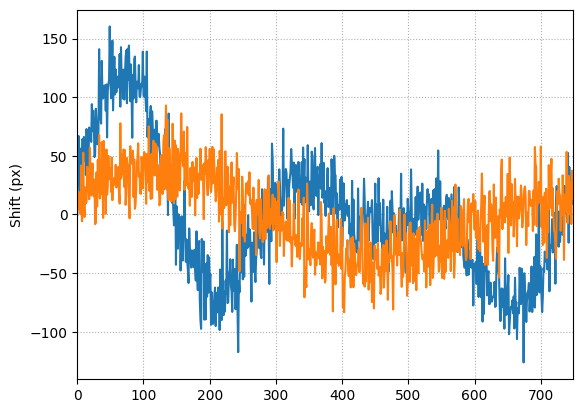

In [10]:
shift = example_utils.get_simulated_displacement_curve(angles, x_mult=50, y_mult=40, noise_coeff=20)

# center around 0
%matplotlib inline
plt.plot(shift)
plt.ylabel("Shift (px)")
plt.autoscale(True, "x", True)
plt.grid(ls=":")
plt.show()

In [ ]:
# shift the projections
projections.shift_manager.stage_shift(shift, function_type=pyxalign.enums.ShiftType.LINEAR)
projections.apply_staged_shift()

In [9]:
projections.undo_last_shift()

*Cross-correlation alignment GUI*
%matplotlib inline
task.options.cross_correlation.remove_slow_variation = True
In the GUI window, click the "start alignment button". After the alignment completes,
the pre-alignment and post-alignment views

In [7]:
# launch cross-correlation alignment GUI
%matplotlib inline
task.options.cross_correlation.remove_slow_variation = True
# after the GUI starts, click 'start alignment'
# the pre-alignment and post-alignment views
cross_correlation_gui = pyxalign.gui.launch_cross_correlation_gui(task, "PHASE")

In [14]:
# after alignment, the shift is automatically stored in a staging area
# use the `apply_staged_shift` method to apply that shift
projections.apply_staged_shift()

In [12]:
projections.undo_last_shift()

In [10]:
plt.plot(task.phase_projections.shift_manager.past_shifts[0] + task.phase_projections.shift_manager.past_shifts[1])
plt.show()

In [12]:
# show the projections object
%matplotlib qt
projection_viewer = pyxalign.gui.launch_projection_viewer(task.phase_projections)

In [ ]:
pma_options = task.options.projection_matching
 # Turn on pre-alignment downsampling of projections
pma_options.downsample.enabled = True 
# Turn on momentum 
pma_options.momentum.enabled = True 
# specify gpus to use for back and forward projection
gpu_list = (0,1,2,3)
pma_options.reconstruct.astra.back_project_gpu_indices = gpu_list
pma_options.reconstruct.astra.forward_project_gpu_indices = gpu_list
# select high pass filter value; this is usually chosen empirically
# by varying it until 
pma_options.high_pass_filter = 0.005
pma_options.iterations = 1000
pma_options.mask_shift_type = pyxalign.enums.ShiftType.FFT
pma_options.keep_on_gpu = True
pma_options.interactive_viewer.update.enabled = True

In [17]:
pma_estimated_shift = {}

In [18]:
%matplotlib qt
pma_options.downsample.scale = 8
pma_estimated_shift[pma_options.downsample.scale] = task.get_projection_matching_shift()
current_shift_estimate = pma_estimated_shift[pma_options.downsample.scale]


Projection-matching shift stored in shift_manager


In [19]:
%matplotlib qt
pma_options.downsample.scale = 4
pma_estimated_shift[pma_options.downsample.scale] = task.get_projection_matching_shift(current_shift_estimate)
current_shift_estimate = pma_estimated_shift[pma_options.downsample.scale]

Projection-matching shift stored in shift_manager


In [20]:
%matplotlib qt
pma_options.downsample.scale = 2
pma_estimated_shift[pma_options.downsample.scale] = task.get_projection_matching_shift(current_shift_estimate)
current_shift_estimate = pma_estimated_shift[pma_options.downsample.scale]

Projection-matching shift stored in shift_manager


In [21]:
%matplotlib qt
pma_options.downsample.scale = 1
pma_estimated_shift[pma_options.downsample.scale] = task.get_projection_matching_shift(current_shift_estimate)
current_shift_estimate = pma_estimated_shift[pma_options.downsample.scale]

Projection-matching shift stored in shift_manager


In [23]:
plt.plot(current_shift_estimate + shift)

In [22]:
np.mean(current_shift_estimate + shift)

np.float32(-0.13641776)

In [11]:
# show the volume in a GUI
volume_gui = pyxalign.gui.launch_volume_viewer(volume_data)
# show the projection data in a GUI
projection_data_gui = pyxalign.gui.launch_array_viewer(projection_data)